# Shared variants analyses

This notebook contains scripts for the following: 

1. Determining the number of times each within-host variant is detected. 
2. Plotting whether variants that occur > 1 time are present in homopolymer regions. 
3. Plotting whether variants that occur > 1 time are also ones identified as problematic/likely errors by people looking at consensus data. I will use this virological post [here](http://virological.org/t/issues-with-sars-cov-2-sequencing-data/473)
4. Plot whether variants that occur > 1 time have been detected in other public datasets. Here I am using those published by [Lythgoe et al.](https://github.com/katrinalythgoe/COVIDdiversity) and [Valesano et al.](https://github.com/lauringlab/SARSCov2_Intrahost)

In [218]:
import imp
import importlib, json
import glob
import re,copy,json
import requests
import pandas as pd 
import numpy as np
    
import rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [219]:
# define colors
# powerful women color palette
#purple: 5248AA
#blue: 7C9BAC
#yellow: ECC58C
#red: 551E32
#green:434A42

# old blue/green color scheme
# s_color = "#A5CDA2"
# ns_color = "#0E7908"
# stop_color = "#073C04"
# fs_color = "#00357D"
# fs_stop_color = "#00142F"

In [292]:
# define which column we want to use to look at variants. Use 'nuc_muts' to characterize variants relative to the 
# Wuhan 1 reference, or 'minor_nuc_muts' to do a consensus-agnostic comparison
variant_column = 'minor_nuc_muts'
frequency_column = 'minor_frequency'

## Read in vcfs and convert to dataframes 

I will only read in the intersection SNVs, meaning the ones that were detected in both technical sequencing replicates. This code will separate this into 2 dataframes, 1 for SNVs and 1 for indels, and will also look up and add in the strain names (necessary for converting from tube numbers, which is how the csvs are labelled). All of this code is contained in the ipython notebook called `vcf-module.ipynb`, which I am just going to import here. By running `return_dataframes`, this will collate all vcfs in the vcf directory, combine into a dataframe, and format that dataframe properly. 

In [293]:
"""to load in an ipython notebook as a module, just run the following. You will now have access to all of the 
functions written in that jupyter notebook"""

%run vcf-module.ipynb

In [294]:
# read in the current date 
from datetime import date
today = date.today()
current_date = str(today.strftime("%Y-%m-%d"))

In [295]:
"""now, input the strain names file/metadata file, the directory containing the vcfs, and return the dataframess"""

strain_names_file = "/Users/lmoncla/src/ncov-WI-within-host/data/sample-metadata.tsv"
fasta_file = "../data/consensus-sequences-2021-01-25.fasta"
clades_file = "../data/clades-file-2020-08-28.txt"
vcf_directory = "../data/vcfs-all/"

# N transcript was a control; sample/tube 6, UW-30, has an snv at basically every single site after a certain 
# point in the genome. it has 418 SNVs!!! I'm excluding it; finally, I am going to exclude tube 127, USA/WI-UW-118/2020
# which has >50 indels and >50 SNVs. It has a pretty high Ct as well, so I think these are probably errors as it is 
# a very clear outlier
# remove 303, 304, 302, 735, and 736 because these are time-series! 
samples_to_ignore = ["N_transcript","6", "127","302","303","304","735","736"]

# set the length of homopolymers that you want to use
homopolymer_length = 3

# set the variant percent that you want to use 
variant_percent = "0.03"

snvs_only, indels_only, all_intersection_variants,metadata_dict = return_dataframes(strain_names_file, clades_file,vcf_directory,samples_to_ignore,fasta_file, homopolymer_length)

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [296]:
"""subset data to include only SNVs and indels >3% frequency"""
snvs_only = snvs_only[snvs_only[frequency_column] >= float(variant_percent)]
indels_only = indels_only[indels_only[frequency_column] >= float(variant_percent)]

"""subset data to include only SNVs and indels <50% frequency"""
snvs_only = snvs_only[snvs_only[frequency_column] <= float(0.5)]
indels_only = indels_only[indels_only[frequency_column] <= float(0.5)]

In [297]:
pd.set_option('display.max_columns', 35)

#snvs_only.to_csv("/Users/lmoncla/src/ncov-WI-within-host/data/all-WI-snvs.tsv", sep="\t")
snvs_only.head()

,Unnamed: 0,SNP,POS_x,rep1_percent,rep2_percent,frequency,sampleid,gene,nt_change,aa_change,annotation,strain_name,location,clade,homopolymer,homopolymer_base,type_of_variant,aa_site,wt_aa,mut_aa,nt_ref,nt_mut,nuc_muts,minor_frequency,consensus_base,minor_base,consensus_aa,minor_aa,minor_nuc_muts,minor_aa_muts
3,8,orf1ab_C>T_Ser2839Ser_synonymous,8782.0,0.9411,0.8919,0.91650,53,orf1ab,C>T,Ser2839Ser,synonymous,USA/WI-UW-67/2020,Dane County,19B,not,[],snv,2839,Ser,Ser,C,T,C8782T,0.08350,T,C,Ser,Ser,T8782C,orf1ab_Ser2839Ser
11,21,orf1ab_G>A_Val5373Ile_missense,16381.0,0.9115,0.9512,0.93135,53,orf1ab,G>A,Val5373Ile,missense,USA/WI-UW-67/2020,Dane County,19B,not,[],snv,5373,Val,Ile,G,A,G16381A,0.06865,A,G,Ile,Val,A16381G,orf1ab_Ile5373Val
12,22,orf1ab_T>C_Thr5871Thr_synonymous,17877.0,0.9542,0.9487,0.95145,53,orf1ab,T>C,Thr5871Thr,synonymous,USA/WI-UW-67/2020,Dane County,19B,not,[],snv,5871,Thr,Thr,T,C,T17877C,0.04855,C,T,Thr,Thr,C17877T,orf1ab_Thr5871Thr
14,27,orf1ab_C>T_Phe6684Phe_synonymous,20316.0,0.9173,0.9239,0.92060,53,orf1ab,C>T,Phe6684Phe,synonymous,USA/WI-UW-67/2020,Dane County,19B,not,[],snv,6684,Phe,Phe,C,T,C20316T,0.07940,T,C,Phe,Phe,T20316C,orf1ab_Phe6684Phe
15,33,ORF3a_G>T_Pro36Pro_synonymous,25500.0,0.9557,0.9679,0.96180,53,ORF3a,G>T,Pro36Pro,synonymous,USA/WI-UW-67/2020,Dane County,19B,not,[],snv,36,Pro,Pro,G,T,G25500T,0.03820,T,G,Pro,Pro,T25500G,ORF3a_Pro36Pro


In [298]:
snvs_only.columns

Index(['Unnamed: 0', 'SNP', 'POS_x', 'rep1_percent', 'rep2_percent',
       'frequency', 'sampleid', 'gene', 'nt_change', 'aa_change', 'annotation',
       'strain_name', 'location', 'clade', 'homopolymer', 'homopolymer_base',
       'type_of_variant', 'aa_site', 'wt_aa', 'mut_aa', 'nt_ref', 'nt_mut',
       'nuc_muts', 'minor_frequency', 'consensus_base', 'minor_base',
       'consensus_aa', 'minor_aa', 'minor_nuc_muts', 'minor_aa_muts'],
      dtype='object')

In [299]:
# double check that no variant classes have been misclassified (this happened occasionally when the vcf formatting changed)
print(set(snvs_only['annotation'].tolist()))
print(set(indels_only['annotation'].tolist()))

{'missense', 'intergenic_region', 'synonymous'}
{'conservative-inframe-deletion', 'frameshift', 'frameshift&stop', 'intergenic_region'}


In [300]:
def classify_Wh1_reversion(row):
    minor_variant = row['minor_nuc_muts']
    wh_variant = row['nuc_muts']
    
    if minor_variant == wh_variant:
        wh_reversion = "no"
    else:
        wh_reversion = "yes"
    
    return(wh_reversion)

In [301]:
# I'm going to try something where I classify SNVs based on whether they are a mostly fixed variant or not 
snvs_only['Wuhan1_reversion'] = snvs_only.apply(classify_Wh1_reversion, axis=1)
indels_only['Wuhan1_reversion'] = indels_only.apply(classify_Wh1_reversion, axis=1)
print(set(indels_only['Wuhan1_reversion'].tolist()))

{'no', 'yes'}


In [302]:
snvs_only[snvs_only['homopolymer']=='no_consensus']
print(set(snvs_only['homopolymer'].tolist()))

{'in', 'not', 'adjacent'}


## Plot the number of times detected vs. the number of variants

I would like a simple summary plot to show the number of variants that are detected x number of times. 

In [323]:
# count up all the snvs and amino acid mutations that are repeated
s_counts = snvs_only[variant_column].value_counts().rename_axis('SNV').reset_index(name='counts')
i_counts = indels_only[variant_column].value_counts().rename_axis('SNV').reset_index(name='counts')

print(len(s), len(i))

226 25


In [324]:
# count up all the snvs and amino acid mutations that are repeated
s_aa = snvs_only['minor_aa_muts'].value_counts().rename_axis('SNV').reset_index(name='counts')
i_aa = indels_only['minor_aa_muts'].value_counts().rename_axis('SNV').reset_index(name='counts')
s_aa.head()

,SNV,counts
0,CHRSTART-orf1ab_NANANA,150
1,orf1ab_Phe924Phe,47
2,orf1ab_Leu4715Pro,42
3,orf1ab_Gln4962His,22
4,orf1ab_Phe6684Phe,13


In [325]:
# add together for a variants dataframe
v = s_counts.append(i_counts)
v.dropna(inplace=True)
print(len(v))

251


In [326]:
# now, output counts for the number of times variants are detected 
v_counts = pd.DataFrame(v['counts'].value_counts())
v_counts.reset_index(inplace=True)
v_counts.columns = ['times_detected','number_variants']
v_counts['proportion_variants'] = v_counts['number_variants']/sum(v_counts['number_variants'])

print(len(v_counts))
v_counts.head()

20


,times_detected,number_variants,proportion_variants
0,1,172,0.685259
1,2,31,0.123506
2,3,17,0.067729
3,4,6,0.023904
4,5,5,0.019920


In [327]:
# what fraction of total variants are found in at least 10 samples? 
print(len(v_counts[v_counts['times_detected'] >= 10]))

11


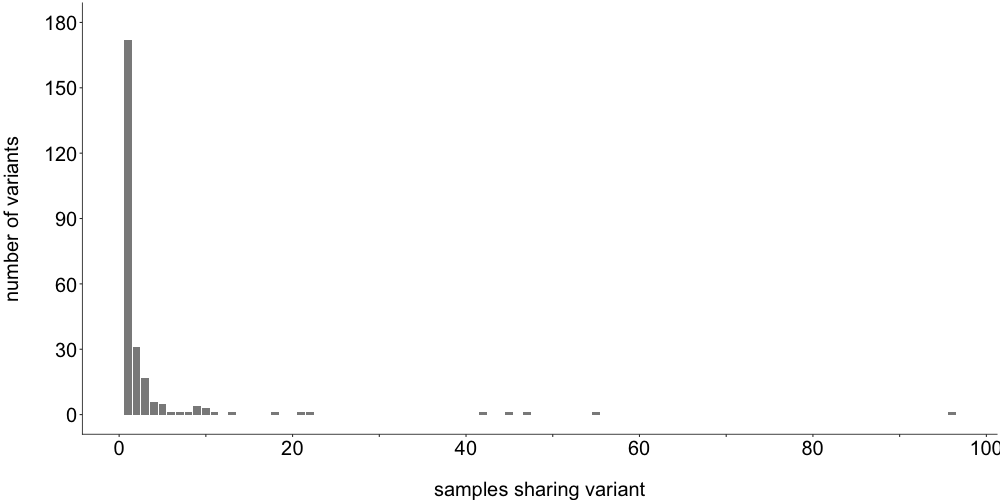

In [310]:
%%R -w 1000 -h 500 -u px -i v_counts,variant_percent,current_date # this sets the size of the plot...otherwise, it will go off the page\n",
require(ggplot2)
library(ggplot2)

output_filename = paste("variants-vs-times-detected-",variant_percent,"percent-",current_date,".pdf", sep="")
v_counts$number_variants = as.numeric(v_counts$number_variants)
v_counts$times_detected = as.numeric(v_counts$times_detected)

p2 <- ggplot(v_counts, aes(x=times_detected, y=number_variants))+
    geom_col(fill="#8B8B8B")+
    #geom_text(aes(x=SNV_f, y=max_count + 2, label=homopolymer_base))+
    #scale_fill_manual(values=c(in_hp=ns_color, not_in_hp=s_color,adjacent=fs_color,no_consensus="grey70"), labels=c(in_hp="in homopolymer region",not_in_hp="not in homopolymer region",adjacent="1 nt away from homopolymer",no_consensus="missing consensus"))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+
    scale_y_continuous(limits=c(0,180), breaks=seq(0,180,30))+
    scale_x_continuous(breaks=seq(0,100,10), labels=c("0","","20","","40","","60","","80","","100"))+
    theme(plot.title=element_text(size=13))+
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(plot.margin=unit(c(0.1,0.1,0.1,0.1),"cm"))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_text(size=20, hjust=0.5, vjust=0.5))+
    theme(axis.title.x=element_text(size=20, vjust=0.5))+
    theme(axis.text.y=element_text(size=20, colour="black"))+
    theme(axis.text.x=element_text(hjust=0.5, vjust=0.5, size=20,colour="black"))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_blank())+
    #theme(legend.position = c(0.9, 0.6))+ # (0,0) is bottom left, (1,1) is top right
    theme(panel.margin=unit(1, "lines"))+
    theme(legend.key.size=unit(0.55, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    labs(x="\nsamples sharing variant",y="number of variants\n")
#       scale_y_continuous(limits=c(-0.1,1.2), breaks=seq(0,1.2,0.2))+


ggsave(output_filename, p2, width = 6, height = 4, path="../figures/individual-pdfs/")
p2

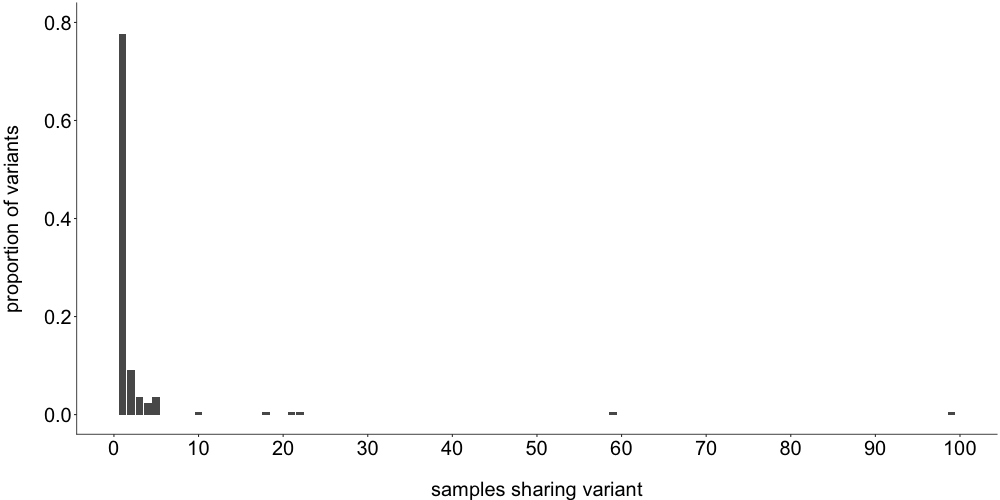

In [34]:
%%R -w 1000 -h 500 -u px -i v_counts,variant_percent,current_date,s_color,ns_color,stop_color,fs_color,fs_stop_color # this sets the size of the plot...otherwise, it will go off the page\n",
require(ggplot2)
library(ggplot2)

output_filename = paste("variants-vs-times-detected-proportions-",variant_percent,"percent-",current_date,".pdf", sep="")
v_counts$number_variants = as.numeric(v_counts$number_variants)
v_counts$times_detected = as.numeric(v_counts$times_detected)

p2 <- ggplot(v_counts, aes(x=times_detected, y=proportion_variants))+
    geom_col(fill="#8B8B8B")+
    #geom_text(aes(x=SNV_f, y=max_count + 2, label=homopolymer_base))+
    #scale_fill_manual(values=c(in_hp=ns_color, not_in_hp=s_color,adjacent=fs_color,no_consensus="grey70"), labels=c(in_hp="in homopolymer region",not_in_hp="not in homopolymer region",adjacent="1 nt away from homopolymer",no_consensus="missing consensus"))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+
    scale_y_continuous(limits=c(0,0.8), breaks=seq(0,0.8,0.2))+
    scale_x_continuous(breaks=seq(0,100,10))+
    theme(plot.title=element_text(size=13))+
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(plot.margin=unit(c(0.1,0.1,0.1,0.1),"cm"))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_text(size=20, hjust=0.5, vjust=0.5))+
    theme(axis.title.x=element_text(size=20, vjust=0.5))+
    theme(axis.text.y=element_text(size=20, colour="black"))+
    theme(axis.text.x=element_text(hjust=0.5, vjust=0.5, size=20,colour="black"))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_blank())+
    #theme(legend.position = c(0.9, 0.6))+ # (0,0) is bottom left, (1,1) is top right
    theme(panel.margin=unit(1, "lines"))+
    theme(legend.key.size=unit(0.55, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    labs(x="\nsamples sharing variant",y="proportion of variants\n")
#       scale_y_continuous(limits=c(-0.1,1.2), breaks=seq(0,1.2,0.2))+


ggsave(output_filename, p2, width = 9, height = 5, path="../figures/individual-pdfs/")
p2

## Write out a little annotations file to drag and drop onto tree

In [328]:
# output a csv that could be used to layer on top of nextstrain to visualize if particular strains have 
# particular within-host mutations
def return_dataframe_for_nextstrain(df, order_of_snvs):
    
    dataframe_to_return = pd.DataFrame()
    
    for strain in set(df['strain_name'].tolist()):
        x = df[df['strain_name'] == strain]
        wh_muts = x['minor_nuc_muts'].tolist()
        
        for s in order_of_snvs: 
            if s in wh_muts: 
                presence = "yes"
            else:
                presence = "no"
                
            local_df = pd.DataFrame.from_dict({"name":[strain],"within-host mutation":[s],"presence":[presence]})
            dataframe_to_return = dataframe_to_return.append(local_df)
            
    return(dataframe_to_return)

In [316]:
df_for_nextstrain = return_dataframe_for_nextstrain(snvs_only, order_of_snvs)
df_for_nextstrain = df_for_nextstrain.pivot(index='name',columns='within-host mutation')
df_for_nextstrain.reset_index(inplace=True)

df_for_nextstrain.to_csv("../annotations-"+variant_percent+"%-"+current_date+".csv")

# Plot shared variants

I would now like to know/plot the following: 
1. what are these shared variants?
2. Do these shared variants predominantly occur within or adjacent to homopolymer regions?
3. Are these variants found in other datasets? 
4. Which of these variants are clade-defining mutations that are nearly fixed?

In [329]:
snvs_more_than_once = s[s['counts'] > 1]
order_of_snvs = snvs_more_than_once['SNV'].tolist() #[::4]

indels_more_than_once = i[i['counts'] > 1]
order_of_indels = indels_more_than_once['SNV'].tolist()# [::4]


print(order_of_snvs)
print(order_of_indels)

['T241C', 'T3037C', 'T14408C', 'G15150T', 'T20316C', 'T8782C', 'C3931T', 'G15168A', 'C17877T', 'C696A', 'T4226C', 'A16381G', 'C7837A', 'C15354T', 'T25500G', 'G23403A', 'T17C', 'C21T', 'A26G', 'C28T', 'C15157A', 'C15141A', 'A22T', 'T25C', 'T2A', 'T18877C', 'C21G', 'T10C', 'G23A', 'A28881G', 'T25563G', 'T10279C', 'C28883G', 'T12880C', 'A28882G', 'C7513T', 'T20148C', 'C15T', 'T2035G', 'T12025C', 'G13T', 'A20056G', 'C2T', 'C241T', 'A2549G', 'T9448C', 'C29077T', 'T3871G', 'C21575T', 'C14A', 'T10G', 'G23C', 'T9A', 'C20T', 'T6500C', 'C3037T', 'G7T', 'T1A', 'C29627T', 'T5A', 'A4T', 'T28854C', 'A15139C', 'C12A', 'G23T', 'C20G', 'T7420C', 'T29711G', 'C7G', 'T18A', 'T14937C', 'C16G']
['-6696T', '-15965T', '-19983T', '-18368T', 'AAGTCATTT685-', '-28214T', '-196CGGTTTCGTCCGT']


In [440]:
# make a combined dataframe to plot shared indels and SNVs together
variants_more_than_once = snvs_more_than_once.append(indels_more_than_once)
variants_more_than_once = variants_more_than_once.sort_values(by=['counts','SNV'], ascending=False)

order_of_variants = variants_more_than_once['SNV'].tolist()#[::4]
print(order_of_variants)
print(len(order_of_variants))

['-6696T', '-15965T', 'T241C', 'T3037C', 'T14408C', 'G15150T', '-19983T', '-18368T', 'T20316C', 'T8782C', 'G15168A', 'C3931T', 'C17877T', 'T4226C', 'C7837A', 'C696A', 'A16381G', 'C15354T', 'T25500G', 'G23403A', 'T17C', 'C28T', 'C21T', 'AAGTCATTT685-', 'A26G', 'T2A', 'T25C', 'T18877C', 'C15157A', 'C15141A', 'A22T', 'T25563G', 'T2035G', 'T20148C', 'T12880C', 'T12025C', 'T10C', 'T10279C', 'G23A', 'G13T', 'C7513T', 'C28883G', 'C21G', 'C15T', 'A28882G', 'A28881G', 'A20056G', '-28214T', 'T9A', 'T9448C', 'T7420C', 'T6500C', 'T5A', 'T3871G', 'T29711G', 'T28854C', 'T1A', 'T18A', 'T14937C', 'T10G', 'G7T', 'G23T', 'G23C', 'C7G', 'C3037T', 'C2T', 'C29627T', 'C29077T', 'C241T', 'C21575T', 'C20T', 'C20G', 'C16G', 'C14A', 'C12A', 'A4T', 'A2549G', 'A15139C', '-196CGGTTTCGTCCGT']
79


## Homopolymer classifications

Add in the counts of each variant and how many times it is found within a homopolymer region or not

In [331]:
def return_homopolymer_counts_of_variants(df):
    
    df_to_return = pd.DataFrame()
    
    for m in set(df[variant_column].tolist()):
        local_df = df[df[variant_column] == m]
        annotations = local_df['homopolymer'].tolist()
        homopolymer_base = local_df['homopolymer_base'].tolist()
        flat_list = [item for sublist in homopolymer_base for item in sublist]

        if len(flat_list) >= 1:
            hp_base = flat_list[0]
        elif len(flat_list) == 0:
            hp_base = ""
        else:
            print(flat_list)

        total_count = len(local_df)
        count_in = annotations.count("in") + annotations.count("adjacent")
        count_not = annotations.count("not")

        x = pd.DataFrame.from_dict({"SNV":[m],"counts":[total_count],"homopolymer_classified_counts":[count_in],"homopolymer_class":["in_hp"], "homopolymer_base":[hp_base]})
        y = pd.DataFrame.from_dict({"SNV":[m],"counts":[total_count],"homopolymer_classified_counts":[count_not],"homopolymer_class":["not_in_hp"], "homopolymer_base":[hp_base]})

        df_to_return = df_to_return.append(x.append(y))
        
        
    return(df_to_return)

## Compare to de Maio masked sites

Using the list of putative masked variants [here](http://virological.org/t/issues-with-sars-cov-2-sequencing-data/473), see if any of these sites are present in the within-host data. 

**They recommend this:**

*Secondly, we propose masking sites that appear to be highly homoplasic and have no phylogenetic signal and/or low prevalence – these can be recurrent artefacts, or otherwise hypermutable low-fitness sites that might similarly cause phylogenetic noise. A current list of these is:
187, 1059, 2094, 3037, 3130, 6990, 8022, 10323, 10741, 11074, 13408, 14786, 19684, 20148, 21137, 24034, 24378, 25563, 26144, 26461, 26681, 28077, 28826, 28854, 29700.
We provide technical details of how these sites were identified below, however please note that all lists of sites outlined here are a work in progress, and might be affected by many choices made in the preliminary phylogenetic steps.*

*In addition, we suggest masking any homoplasic positions that are exclusive to a single sequencing lab or geographic location, regardless of phylogenetic signal. Here the phylogenetic signal might be caused by a common source of error (among other things). Our current list is:
4050, 13402.*

*We also recommend masking of positions that, despite having strong phylogenetic signal, are also strongly homoplasic. These may be caused by hypermutability at certain positions, although it is hard to rule out any possibility for now. Our current list is:
11083, 15324, 21575*


This paragraph of that blog is particularly useful. They split up all of the consensus sequences into those generated by nanopore, Illumina, or by KU Leuven. This is what they found: 

*We re-analysed these 3 datasets individually using TreeTime. The most predominant homoplasies were common across technology and country, including G11083T, C16887T, C21575T and C15324T. Others were exclusive to Illumina (most remarkably C11074T, C6990T, C29353T, and C29774T) while others were exclusive to nanopore. Surprisingly dataset C contained more homoplasies than B (Figure 8), of which many are mutations only found in C (e.g. T13402G, A4050C, T13408C, T8022G, C3130T, T28785G). Each of these homoplasies could in principle also be caused by issues with phylogenetic inference, which itself can be affected by homoplasic substitutions.*

They also note that some of these recurrent mutations, like at 11083 and 11074 extend long homopolymer T regions. 11074 is also Illumina specific in their analysis. They note that 11083 reverts multiple times on the tree as well.

In [334]:
def return_de_Maio_classification(SNV):
    masked_sites = [187, 1059, 2094, 3037, 3130, 6990, 8022, 10323, 10741, 11074, 13408, 14786, 19684, 20148, 21137, 24034, 24378, 25563, 26144, 26461, 26681, 28077, 28826, 28854, 29700]
    lab_specific = [4050, 13402]
    homoplasic = [11083, 15324, 21575]
    illumina_specific = ["C11074T", "C6990T", "C29353T", "C29774T"]
    
    # remove all nondigits
    site = int(''.join(filter(str.isdigit, SNV)))
    if SNV in illumina_specific: 
        annotation = "illumina_specific"
    elif site in masked_sites: 
        annotation = "masked"
    elif site in lab_specific: 
        annotation = "lab_specific"
    elif site in homoplasic:
        annotation = "homoplasic"
    else:
        annotation = "none"
    
    return(annotation)

## Compare to Lythgoe, SCAN, and Valesano sites sites

They very conveniently have their SNVs available in their github repo, [here](https://github.com/katrinalythgoe/COVIDdiversity) -> however, it looks like that file has now been deleted. I think that they updated their results, so maybe they will put up a new file. 

In [335]:
def read_in_lythgoe_sites(lythgoe_input_file):
    lythgoe_dict = {}
    
    with open(lythgoe_input_file, "r") as infile: 
        for line in infile: 
            if "reference_position" not in line: 
                site = int(line.split(",")[0])
                counts_within_host = line.split(",")[6]
                lythgoe_dict[site] = {"within-host-counts":counts_within_host}
    
    return(lythgoe_dict)

In [336]:
def read_in_scan_sites(scan_input_file):
    scan_sites = {}
    
    with open(scan_input_file, "r") as infile: 
        for line in infile:
            if "snv" not in line:
                site = int(line.split("\t")[0][:-1])
                counts = line.split("\t")[1]
            
                scan_sites[site] = counts
            
    return(scan_sites)

In [337]:
def read_in_valesano_sites(valesano_input_file):
    valesano_dict = {}
    
    with open(valesano_input_file, "r") as infile: 
        for line in infile: 
            if "REGION" not in line: 
                site = int(line.split(",")[2])
                ref = line.split(",")[3].replace("\"","")
                var = line.split(",")[4].replace("\"","")
                mut = ref + str(site) + var
                
                if mut in valesano_dict:
                    valesano_dict[mut] += 1
                else: 
                    valesano_dict[mut] = 1
                    
    return(valesano_dict)

In [338]:
def return_classification(SNV, lythgoe_dict, scan_dict, valesano_dict):
    # remove all nondigits
    site = int(''.join(filter(str.isdigit, SNV)))
    
    annotations = []
    
    if site in lythgoe_dict: 
        annotations.append("lythgoe_site")
    if site in scan_dict:
        annotations.append("scan_site")
    if SNV in valesano_dict:  # for Valesano data, we have the full SNV, while for Lythgoe we just have site
        annotations.append("valesano_site")  
    
    if len(annotations) == 0:
        annotation = "none"
    else:
        annotation = "_".join(annotations)
        
    return(annotation)

In [339]:
def return_lythgoe_counts(SNV, lythgoe_dict):

    # remove all nondigits
    site = int(''.join(filter(str.isdigit, SNV)))
    if site in lythgoe_dict: 
        counts = int(lythgoe_dict[site]['within-host-counts'])
    else:
        counts = 0
    
    return(counts)

In [340]:
def return_label(row):
    counts = int(row['counts'])
    lythgoe_counts = int(row['lythgoe_counts'])
    snv = row['SNV']
    
    if counts >= 20 or lythgoe_counts >= 20:
        label = snv
    else:
        label = ""
        
    return(label)

## Add annotation for whether a Wuhan1 reversion and homopolymer

In [341]:
def make_Wuhan1_dict(df):
    
    Wuhan1_dict = {}
    
    for m in set(df[variant_column].tolist()):
        local_df = df[df[variant_column] == m]
        annotations = local_df['Wuhan1_reversion'].tolist()

        total_count = len(local_df)
        count_reversion = annotations.count("yes")
        count_not = annotations.count("no")
        
        # If there is ever an instance where a variant is found as a reversion and not, print the variant
        if count_reversion != total_count and count_not != total_count:
            print(m)
        elif count_reversion != 0 and count_not != 0:
            print(m)
        
        # otherwise, we can safely classify the variant as either a reversion or not
        else:
            if count_reversion > count_not:
                annotation = "Wuhan1_reversion"
            else:
                annotation = "not_Wuhan1_reversion"
        
        Wuhan1_dict[m] = annotation
        
    return(Wuhan1_dict)

In [342]:
def return_Wuhan1_reversion_classification(SNV, Wuhan1_dict):
    if SNV in Wuhan1_dict: 
        annotation = Wuhan1_dict[SNV]
    else:
        print(SNV)
        annotation = "unknown"
        
    return(annotation)

## run it

In [355]:
s = return_homopolymer_counts_of_variants(snvs_only)
s = s.sort_values(by=['counts','SNV'], ascending=False)

i = return_homopolymer_counts_of_variants(indels_only)
i = i.sort_values(by=['counts','SNV'], ascending=False)

# add together for a variants dataframe
v = s.append(i)
v.dropna(inplace=True)
print(len(v))

502


In [356]:
variants_more_than_once = v[v['counts'] > 1]
variants_more_than_once = variants_more_than_once.sort_values(by=['counts','SNV'], ascending=False)

order_of_variants = variants_more_than_once['SNV'].tolist()[::2]
print(order_of_variants)

['-6696T', '-15965T', 'T241C', 'T3037C', 'T14408C', 'G15150T', '-19983T', '-18368T', 'T20316C', 'T8782C', 'G15168A', 'C3931T', 'C17877T', 'T4226C', 'C7837A', 'C696A', 'A16381G', 'C15354T', 'T25500G', 'G23403A', 'T17C', 'C28T', 'C21T', 'AAGTCATTT685-', 'A26G', 'T2A', 'T25C', 'T18877C', 'C15157A', 'C15141A', 'A22T', 'T25563G', 'T2035G', 'T20148C', 'T12880C', 'T12025C', 'T10C', 'T10279C', 'G23A', 'G13T', 'C7513T', 'C28883G', 'C21G', 'C15T', 'A28882G', 'A28881G', 'A20056G', '-28214T', 'T9A', 'T9448C', 'T7420C', 'T6500C', 'T5A', 'T3871G', 'T29711G', 'T28854C', 'T1A', 'T18A', 'T14937C', 'T10G', 'G7T', 'G23T', 'G23C', 'C7G', 'C3037T', 'C2T', 'C29627T', 'C29077T', 'C241T', 'C21575T', 'C20T', 'C20G', 'C16G', 'C14A', 'C12A', 'A4T', 'A2549G', 'A15139C', '-196CGGTTTCGTCCGT']


In [357]:
variants_more_than_once.head()

,SNV,counts,homopolymer_classified_counts,homopolymer_class,homopolymer_base
0,-6696T,96,95,in_hp,a
0,-6696T,96,1,not_in_hp,a
0,-15965T,55,1,in_hp,t
0,-15965T,55,54,not_in_hp,t
0,T241C,47,43,in_hp,a


In [358]:
Wh1_dict = make_Wuhan1_dict(snvs_only.append(indels_only))
variants_more_than_once['Wuhan1_reversion_class'] = variants_more_than_once['SNV'].apply(return_Wuhan1_reversion_classification, args=[Wh1_dict])

In [359]:
lythgoe_input_file = "../data/variants-other-datasets/lythgoe-shared-sites-2020-12-14.tsv"
lythgoe_dict = read_in_lythgoe_sites(lythgoe_input_file)

scan_input_file = "../data/variants-other-datasets/SNV_sites_SCAN.tsv"
scan_dict = read_in_scan_sites(scan_input_file)

valesano_input_file = "../data/variants-other-datasets/Valesano-processed.variants.csv"
valesano_dict = read_in_valesano_sites(valesano_input_file)

In [360]:
variants_more_than_once['de_Maio_class'] = variants_more_than_once['SNV'].apply(return_de_Maio_classification)
variants_more_than_once['other_datasets'] = variants_more_than_once['SNV'].apply(return_classification, args=[lythgoe_dict, scan_dict, valesano_dict])

variants_more_than_once.head()

,SNV,counts,homopolymer_classified_counts,homopolymer_class,homopolymer_base,Wuhan1_reversion_class,de_Maio_class,other_datasets
0,-6696T,96,95,in_hp,a,not_Wuhan1_reversion,none,none
0,-6696T,96,1,not_in_hp,a,not_Wuhan1_reversion,none,none
0,-15965T,55,1,in_hp,t,not_Wuhan1_reversion,none,none
0,-15965T,55,54,not_in_hp,t,not_Wuhan1_reversion,none,none
0,T241C,47,43,in_hp,a,Wuhan1_reversion,none,lythgoe_site


## First, plot colored by whether you are in a hompolymer region

In [363]:
variants_more_than_once['color'] = variants_more_than_once['homopolymer_class'] + "_" + variants_more_than_once['Wuhan1_reversion_class']
print(set(variants_more_than_once['color'].tolist()))

{'not_in_hp_not_Wuhan1_reversion', 'in_hp_Wuhan1_reversion', 'not_in_hp_Wuhan1_reversion', 'in_hp_not_Wuhan1_reversion'}


In [389]:
times_detected_cutoff_to_plot = 2

purple = "#5248AA"
blue = "#7C9BAC"
#blue = "#7A9CAF"
yellow = "#ECC58C" #EECC9A
red = "#551E32"
green = "#434A42"
grey = "#D3D3D4"

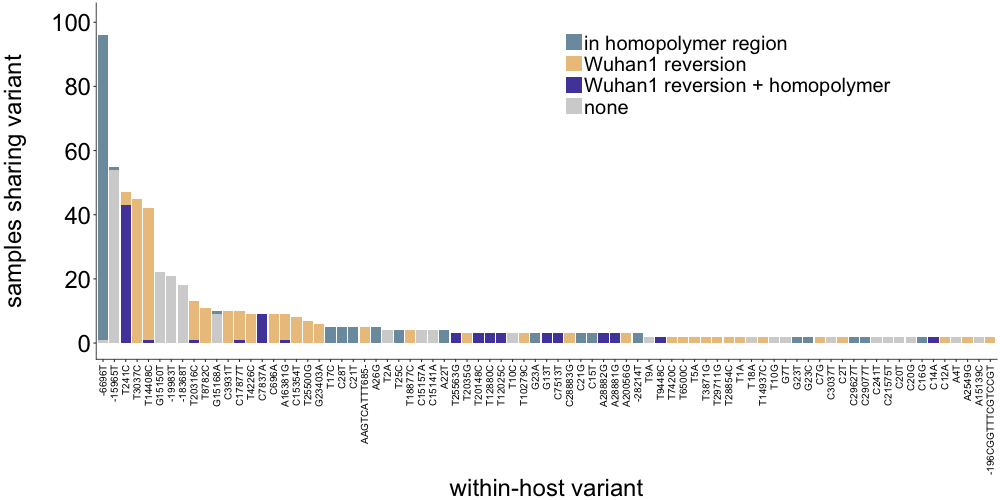

In [434]:
%%R -w 1000 -h 500 -u px -i times_detected_cutoff_to_plot,variant_percent,current_date,variants_more_than_once,order_of_variants,purple,blue,yellow,red,green,grey # this sets the size of the plot...otherwise, it will go off the page\n",
require(ggplot2)
library(ggplot2)

# subset to only SNVs present in more than 3 times
variants_more_than_once <- variants_more_than_once[(variants_more_than_once$counts>=times_detected_cutoff_to_plot),]

output_filename = paste("counts-variants-3bp-homopolymer-",variant_percent,"percent-",current_date,".pdf", sep="")

variants_more_than_once$SNV_f = factor(variants_more_than_once$SNV, levels=c(order_of_variants))
variants_more_than_once$color_f = factor(variants_more_than_once$color, levels=c("in_hp_not_Wuhan1_reversion", "not_in_hp_Wuhan1_reversion","in_hp_Wuhan1_reversion", "not_in_hp_not_Wuhan1_reversion"))
max_count = max(variants_more_than_once$counts)

p2 <- ggplot(variants_more_than_once, aes(x=SNV_f, y=homopolymer_classified_counts, fill=color_f))+
    geom_col()+
    #geom_text(aes(x=SNV_f, y=max_count + 2, label=homopolymer_base))+
    scale_fill_manual(values=c(in_hp_Wuhan1_reversion=purple, not_in_hp_Wuhan1_reversion=yellow, not_in_hp_not_Wuhan1_reversion=grey, in_hp_not_Wuhan1_reversion=blue), labels=c(in_hp_Wuhan1_reversion="Wuhan1 reversion + homopolymer", not_in_hp_Wuhan1_reversion="Wuhan1 reversion", not_in_hp_not_Wuhan1_reversion="none", in_hp_not_Wuhan1_reversion="in homopolymer region"))+
    scale_linetype_manual(values=c(Wuhan1_reversion=1,not_Wuhan1_reversion=0))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+
    scale_y_continuous(limits=c(0,max_count + 5), breaks=seq(0,max_count+5,20))+
    theme(plot.title=element_text(size=13))+
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(plot.margin=unit(c(0.1,0.1,0.1,0.1),"cm"))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_text(size=24, hjust=0.5, vjust=0.5))+
    theme(axis.title.x=element_text(size=24, vjust=0.5))+
    theme(axis.text.y=element_text(size=24, colour="black"))+
    theme(axis.text.x=element_text(hjust=1, vjust=0.5, size=10, angle=90,colour="black"))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(legend.position = c(0.7, 0.8))+ # (0,0) is bottom left, (1,1) is top right; x,y
    #theme(legend.spacing.y = unit(2.5, 'cm'))+
    theme(panel.margin=unit(1, "lines"))+
    theme(legend.key.size=unit(0.75, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    labs(x="within-host variant",y="samples sharing variant\n")+
    guides(fill = guide_legend(nrow = 4, override.aes = list(size=4, linetype=0)))

ggsave(output_filename, p2, width = 11, height = 6, path="../figures/individual-pdfs/")
p2

In [409]:
other_datasets_df = variants_more_than_once.iloc[::2, :]
other_datasets_df.dropna(inplace=True)
other_datasets_df.head()

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,index,SNV,counts,homopolymer_classified_counts,homopolymer_class,homopolymer_base,Wuhan1_reversion_class,de_Maio_class,other_datasets,color
0,0,-6696T,96,95,in_hp,a,not_Wuhan1_reversion,none,none,in_hp_not_Wuhan1_reversion
2,0,-15965T,55,1,in_hp,t,not_Wuhan1_reversion,none,none,in_hp_not_Wuhan1_reversion
4,0,T241C,47,43,in_hp,a,Wuhan1_reversion,none,lythgoe_site,in_hp_Wuhan1_reversion
6,0,T3037C,45,0,in_hp,,Wuhan1_reversion,masked,lythgoe_site,in_hp_Wuhan1_reversion
8,0,T14408C,42,1,in_hp,,Wuhan1_reversion,none,lythgoe_site,in_hp_Wuhan1_reversion


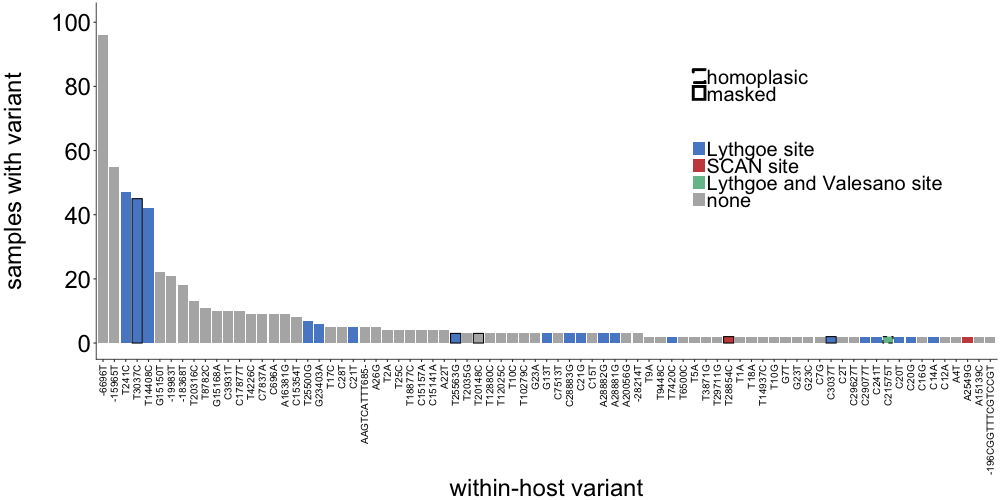

In [439]:
%%R -w 1000 -h 500 -u px -i times_detected_cutoff_to_plot,variant_percent,current_date,other_datasets_df,order_of_variants # this sets the size of the plot...otherwise, it will go off the page\n",
require(ggplot2)
library(ggplot2)

other_datasets_df <- other_datasets_df[(other_datasets_df$counts>=times_detected_cutoff_to_plot),]

output_filename = paste("counts-variants-other-datasets-",variant_percent,"percent-",current_date,".pdf", sep="")

other_datasets_df$SNV_f = factor(other_datasets_df$SNV, levels=c(order_of_variants))
other_datasets_df$other_datasets_f = factor(other_datasets_df$other_datasets, levels=c("lythgoe_site","scan_site","valesano_site",'lythgoe_site_valesano_site',"none"))
max_count = max(other_datasets_df$counts)

p2 <- ggplot(other_datasets_df, aes(x=SNV_f, y=counts, fill=other_datasets_f,linetype=de_Maio_class))+
    geom_col(color= "black")+
    scale_fill_manual(values=c(lythgoe_site="#598ACD", none="grey70",valesano_site="#EDDD80",scan_site="#C94D4B",lythgoe_site_valesano_site="#75BF9A"), labels=c(lythgoe_site="Lythgoe site",scan_site="SCAN site",valesano_site="Valesano site",lythgoe_site_valesano_site="Lythgoe and Valesano site",none="none"))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+
    scale_y_continuous(limits=c(0,max_count+5), breaks=seq(0,max_count+5,20))+
    scale_linetype_manual(values=c(homoplasic=2,masked=1,none=0), labels=c(homoplasic="homoplasic", masked="masked",none=""))+
    theme(plot.title=element_text(size=13))+
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(plot.margin=unit(c(0.1,0.1,0.1,0.1),"cm"))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_text(size=24, hjust=0.5, vjust=0.5))+
    theme(axis.title.x=element_text(size=24, vjust=0.5))+
    theme(axis.text.y=element_text(size=24, colour="black"))+
    theme(axis.text.x=element_text(hjust=1, vjust=0.5, size=10, angle=90,colour="black"))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(legend.position = c(0.8, 0.6))+ # (0,0) is bottom left, (1,1) is top right; x,y
    theme(panel.margin=unit(1, "lines"))+
    theme(legend.key.size=unit(0.55, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    theme(legend.background = element_rect(color = "white", linetype = "solid"))+
    labs(x="within-host variant",y="samples with variant\n")+
    guides(fill = guide_legend(nrow = 5, override.aes = list(size=3.5, linetype=0)))+
    guides(linetype = guide_legend(nrow = 3, override.aes = list(size=2, fill=NA)))


ggsave(output_filename, p2, width = 11, height = 6, path="../figures/individual-pdfs/")
p2

## Check for 501YV1 an V2 sites: 

got the 501V1 sites here: https://virological.org/t/preliminary-genomic-characterisation-of-an-emergent-sars-cov-2-lineage-in-the-uk-defined-by-a-novel-set-of-spike-mutations/563

501v2 sites here: https://virological.org/t/tracking-the-international-spread-of-sars-cov-2-lineages-b-1-1-7-and-b-1-351-501y-v2/592

B.1.1.7:
orf1ab:T1001I; orf1ab:A1708D;
orf1ab:I2230T; del:11288:9; del:21765:6;
del:21991:3; S:N501Y; S:A570D; S:P681H;
S:T716I; S:S982A; S:D1118H; Orf8:Q27*;
Orf8:R52I; Orf8:Y73C; N:D3L; N:S235F

B.1.351/501Y-V2:
E:P71L; N:T205I; orf1a:K1655N; S:D80A;
S:D215G; S:K417N; S:E484K; S:N501Y;
S:E484K

In [411]:
def return_VOC_classification(SNV, b117_list, b1351_list):
    if SNV in b117_list: 
        classification = "B.1.1.7"
    elif SNV in b1351_list:
        classification = "B.1.351"
    else:
        classification = ""
    return(classification)

In [412]:
b117_nt_list = ["C3267T","C5388A","T6954C","11288-11296 deletion","21765-21770 deletion","21991-21993 deletion","A23063T","C23271A","C23604A","C23709T","T24506G","G24914C","C27972T","G28048T","A28111G","28280 GAT->CTA","C28977T"]
b117_aa_list = ["orf1ab_Thr1001Ile","orf1ab_Ala1708Asp","orf1ab_Ile2230Thr","orf1ab_SGF 3675-3677 deletion","S_HV 69-70 deletion","S_Y144 deletion","S_Asn501Tyr","S_Ala570Asp","S_Pro681His","S_Thr716Ile","S_Ser982Ala","S_Asp1118His","orf8_Gln27*","orf9_Arg52Ile","orf10_Tyr73Cys","N_Asp3Leu","N_Ser235Phe"]

b1351_aa_list = ["E_Pro71Leu","N_Thr205Ile","orf1a_Lys1655Asn","S_Asp80Ala","S_Apr215Gly","S_Lys417Asn","S_Asn501Tyr","S_Glu484Lys"]

In [413]:
s_aa['VOC'] = s_aa['SNV'].apply(return_VOC_classification, args=[b117_aa_list, b1351_aa_list])
print(set(s_aa['VOC'].tolist()))
s_aa[s_aa['VOC'] != '']

{'', 'B.1.351'}


,SNV,counts,VOC
143,N_Thr205Ile,1,B.1.351
